In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Define the path to your dataset folder in Google Drive
data_dir = '/content/drive/MyDrive/lung_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 224
label_map = {'Benign cases': 0, 'Malignant cases': 1, 'Normal cases': 2}

data = []
labels = []

print("\n🔄 Loading and preprocessing images...")
for label in label_map:
    folder = os.path.join(data_dir, label)
    if os.path.isdir(folder):
        for img_name in tqdm(os.listdir(folder), desc=label):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                data.append(img)
                labels.append(label_map[label])

X = np.array(data)
y = np.array(labels)

print("Labels in full dataset:", np.unique(y, return_counts=True))



🔄 Loading and preprocessing images...


Normal cases: 100%|██████████| 416/416 [00:07<00:00, 55.06it/s]


Labels in full dataset: (array([0, 1, 2]), array([120, 561, 416]))


In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print("Test label counts:", np.bincount(y_test))

Test label counts: [ 48 225 166]


In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 (no top classifier, use average pooling)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')
base_model.trainable = False

# Preprocess input for EfficientNet
X_train_pp = preprocess_input(X_train.copy())
X_test_pp = preprocess_input(X_test.copy())

print("\n🔎 Extracting CNN features using EfficientNetB0...")
X_train_feat = base_model.predict(X_train_pp, verbose=1)
X_test_feat = base_model.predict(X_test_pp, verbose=1)


🔎 Extracting CNN features using EfficientNetB0...
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


In [18]:
import os

data_dir = '/content/drive/MyDrive/lung_dataset'  # update if needed
print("Folders found in dataset:")
for folder in os.listdir(data_dir):
    print("-", folder)


Folders found in dataset:
- IQ-OTH_NCCD lung cancer dataset.txt
- Malignant cases
- Normal cases
- Benign cases



📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        48
   Malignant       0.51      1.00      0.68       225
      Normal       0.00      0.00      0.00       166

    accuracy                           0.51       439
   macro avg       0.17      0.33      0.23       439
weighted avg       0.26      0.51      0.35       439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


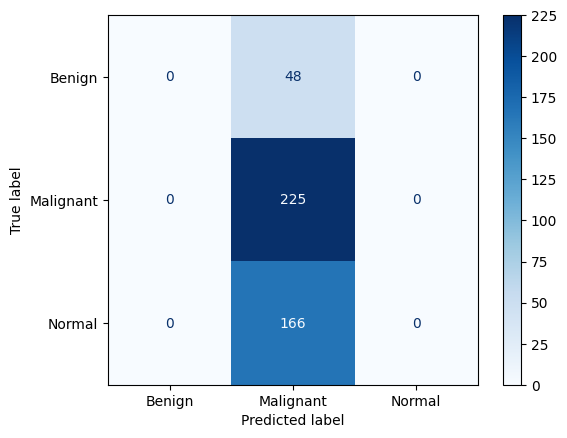

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

svm = SVC(kernel='rbf', C=10, gamma='scale', decision_function_shape='ovr')
svm.fit(X_train_feat, y_train)

y_pred = svm.predict(X_test_feat)

print("\n📋 Classification Report:")
import numpy as np
from sklearn.metrics import classification_report

# Dynamically get the labels actually present in y_test
labels_present = np.unique(y_test)

# Map numeric labels to class names
all_class_names = ['Benign', 'Malignant', 'Normal']
target_names_present = [all_class_names[i] for i in labels_present]

# Print classification report using only the present classes
print(classification_report(
    y_test, y_pred,
    labels=labels_present,
    target_names=target_names_present
))


cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay

# Only use labels present in test set
ConfusionMatrixDisplay(cm, display_labels=target_names_present).plot(cmap='Blues')


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_719']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


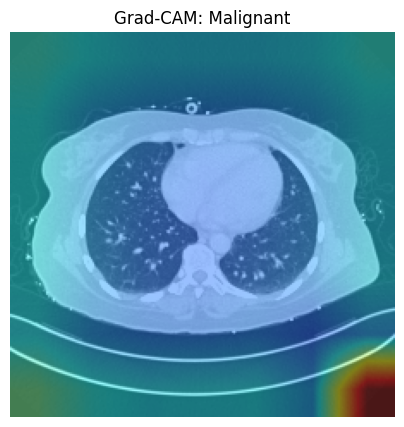

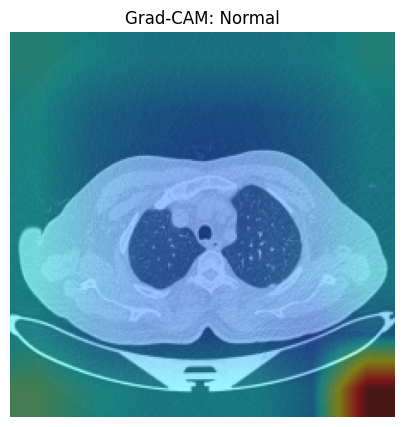

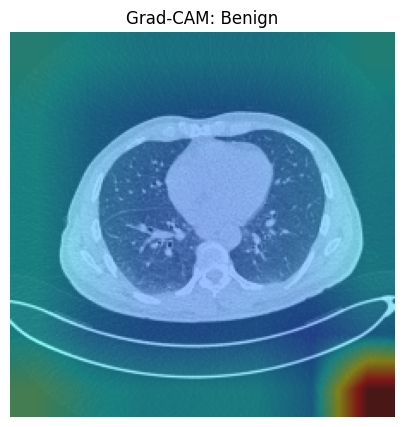

In [20]:
# Build full EfficientNetB0 with classifier
cnn_model = EfficientNetB0(weights="imagenet", include_top=True)

# Grad-CAM utility function
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay function
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2BGR), 1-alpha, heatmap, alpha, 0)
    return overlayed

# Get one example from each class
class_names = ['Benign', 'Malignant', 'Normal']
examples = {}
for i, label in enumerate(y_test):
    if label not in examples:
        examples[label] = i
    if len(examples) == 3:
        break

# Generate Grad-CAMs
import matplotlib.pyplot as plt

for label, idx in examples.items():
    img = X_test[idx]
    img_input = np.expand_dims(preprocess_input(img.copy()), axis=0)

    heatmap = get_gradcam_heatmap(cnn_model, img_input, last_conv_layer_name="top_conv")
    overlay = display_gradcam(img, heatmap)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {class_names[label]}")
    plt.axis('off')
    plt.show()


In [21]:
# Find one sample index from each class in the full dataset (not just test set)
examples = {}
for i, label in enumerate(y):
    if label not in examples:
        examples[label] = i
    if len(examples) == 3:
        break

print("Selected example indices:", examples)


Selected example indices: {np.int64(0): 0, np.int64(1): 120, np.int64(2): 681}


In [22]:
# Force-find 1 image from each class manually
benign_idx = next((i for i, label in enumerate(y) if label == 0), None)
malignant_idx = next((i for i, label in enumerate(y) if label == 1), None)
normal_idx = next((i for i, label in enumerate(y) if label == 2), None)

examples = {
    0: benign_idx,
    1: malignant_idx,
    2: normal_idx
}

print("Manually selected example indices:", examples)


Manually selected example indices: {0: 0, 1: 120, 2: 681}


In [23]:
import os

data_dir = '/content/drive/MyDrive/lung_dataset'  # update if needed
print("Folders in your dataset:")
print(os.listdir(data_dir))


Folders in your dataset:
['IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Normal cases', 'Benign cases']
